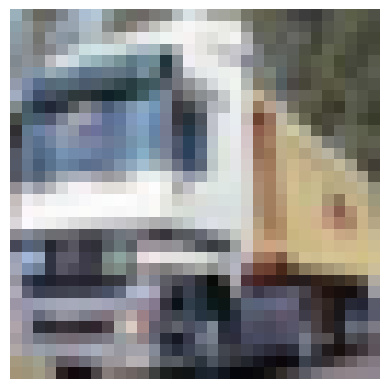

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
# from skimage.feature.texture import greycomatrix, greycoprops

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'classification'))
sys.path.append(project_root)

from cifar10.unpickle import get_data, get_test_data

data, labels = get_data(1)
i = 1
img = data[i]
plt.imshow(data[i])
plt.axis("off")
plt.show()

<h1 style="font-size: 50px; font-weight: bold;">Color</h1>

## 1. Raw Pixel Intensities (Flattened)

**What it shows:**
Every pixel’s raw value in sequence. For a 32×32×3 RGB image, you have 3 × 1024 = 3072 intensity values.

**How it works:**

1. **Flatten** the 3-D array `[H,W,C]` into a 1-D array of length `H×W×C`.
2. Plot the resulting sequence of values.

This plot tells you nothing about spatial structure, but it gives a direct look at the distribution of intensities as they occur in memory.

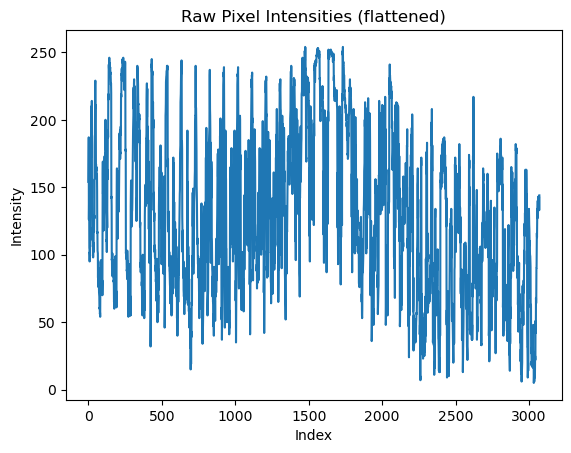

In [6]:
# 1. Raw pixel intensities (flattened line plot)
pixels = img.flatten()
plt.figure()
plt.plot(pixels)
plt.title("Raw Pixel Intensities (flattened)")
plt.xlabel("Index")
plt.ylabel("Intensity")
plt.show()

## 2. Color Histogram

**What it shows:**
The distribution (frequency) of pixel values separately for each channel (R, G, B).

**How it works:**

1. **Separate** the image into its three channels.
2. For each channel, **bin** its 0–255 values into, say, 16 equal‐width bins.
3. **Count** how many pixels fall into each bin.
4. **Plot** the three histograms (often semi‐transparent overlaid).

This captures global color information but discards any notion of where colors appear.

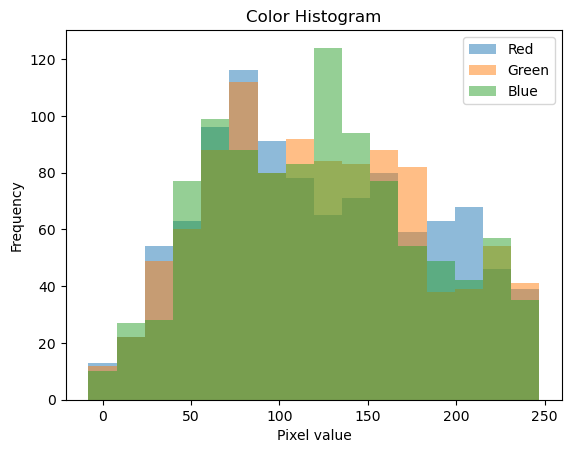

In [7]:
# 2. Color histogram (RGB channels)
plt.figure()
for i, col in enumerate(['Red', 'Green', 'Blue']):
    channel = img[:, :, i]
    hist, bins = np.histogram(channel, bins=16, range=(0, 255))
    plt.bar(bins[:-1], hist, width=bins[1]-bins[0], alpha=0.5, label=col)
plt.title("Color Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

<h1 style="font-size: 50px; font-weight: bold;">Shape</h1>

## 3. HOG (Histogram of Oriented Gradients) Visualization

**What it shows:**
A “sketch” of the dominant edge directions in local patches of the image.

**How it works:**

1. Convert to grayscale.
2. Compute horizontal and vertical **gradients** (via small derivative filters).
3. For each small patch (e.g. an 8×8 cell), **quantize** each pixel’s gradient angle into one of 9 orientation bins (0°, 20°, … 160°), weighted by gradient magnitude.
4. **Normalize** histograms across overlapping blocks of cells.
5. The “HOG image” plots those local histograms as little line segments whose orientation and brightness reflect the bin counts.

HOG highlights the underlying shape and edge structure.

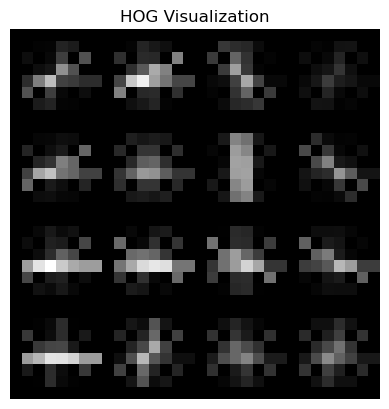

In [8]:
# 3. HOG feature visualization
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hog_feats, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys',
                           visualize=True)
plt.figure()
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()

## 4. Haar-like Feature Rectangles

**What it shows:**
Locations where we’d compute sums and differences of pixel regions to detect simple edge or line patterns.

**How it works:**

1. Overlay a set of predefined rectangles (e.g. 16×16 pixel windows).
2. Given an **integral image**—a summed‐area table of the grayscale image—you can in O(1) compute the sum of any rectangle.
3. A Haar feature is typically a difference between sums of adjacent rectangles (e.g. left half vs. right half).

Although our demo merely draws the rectangles, in a detector you’d take those differences as features sensitive to dark-to-light transitions.

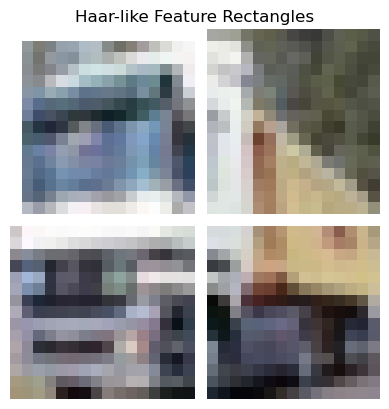

In [9]:
# 4. Haar-like rectangles overlay
rects = [(0, 0, 16, 16), (16, 16, 16, 16)]
overlay = img.copy()
for (x, y, w, h) in rects:
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 255, 255), 1)
plt.figure()
plt.imshow(overlay)
plt.title("Haar-like Feature Rectangles")
plt.axis('off')
plt.show()

<h1 style="font-size: 50px; font-weight: bold;">Texture</h1>

## 5. LBP (Local Binary Patterns) Image

**What it shows:**
A coded texture map: each center pixel is replaced by a small integer whose bits record whether its neighbors are brighter or darker.

**How it works:**

1. For each pixel, compare it to its P neighbors on a circle of radius R.
2. If a neighbor ≥ the center, emit a “1”; else emit “0.”
3. Concatenate those bits into a P-bit code (0–255 for P=8).
4. (Our demo displays the raw code at each pixel.)

LBP is invariant to monotonic gray‐level shifts and captures micro-texture.

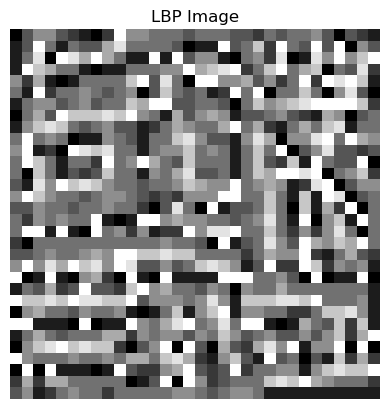

In [10]:
# 5. Local Binary Pattern (LBP) image
lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
plt.figure()
plt.imshow(lbp, cmap='gray')
plt.title("LBP Image")
plt.axis('off')
plt.show()

## 6. Gabor Filter Response

**What it shows:**
How strongly the image contains texture at a particular orientation and spatial scale.

**How it works:**

1. Define a Gabor filter kernel: a cosine (or sine) grating modulated by a Gaussian envelope.
2. **Convolve** the grayscale image with that kernel.
3. The real part highlights regions where that particular frequency/orientation is present.

Plotting the filtered image shows you where “stripes” of a given orientation/scale appear.

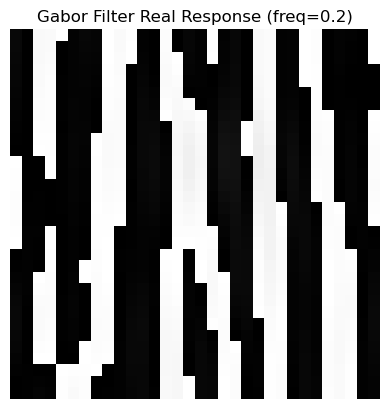

In [11]:
# 6. Gabor filter responses (show real part for freq=0.2)
real, imag = gabor(gray, frequency=0.2)
plt.figure()
plt.imshow(real, cmap='gray')
plt.title("Gabor Filter Real Response (freq=0.2)")
plt.axis('off')
plt.show()

## 7. Haralick (GLCM) Features

**What it shows:**
Six summary statistics of the image’s gray-level **co-occurrence matrix**:
contrast, dissimilarity, homogeneity, energy, correlation, and ASM.

**How it works:**

1. Build a matrix $M$ where $M[i,j]$ counts how often a pixel of intensity i appears next to (e.g. to the right of) a pixel of intensity j.
2. Normalize $M$ so it sums to 1.
3. Compute formulas over $M$: e.g.

   * **Contrast** = $\sum_{i,j}|i−j|^2\,M[i,j]$
   * **Energy** = $\sum_{i,j}M[i,j]^2$, etc.
4. Plot those six values as a bar chart.

Haralick features capture global texture patterns, such as how coarse or smooth the texture is.

In [12]:
# # 7. Haralick features bar chart
# glcm = greycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
# props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
# haralick_vals = [greycoprops(glcm, prop)[0, 0] for prop in props]
# plt.figure()
# plt.bar(props, haralick_vals)
# plt.title("Haralick Texture Features")
# plt.ylabel("Value")
# plt.xticks(rotation=45)
# plt.show()

<h1 style="font-size: 50px; font-weight: bold;">Local features</h1>

## 8. ORB Keypoints (Proxy for BoVW)

**What it shows:**
Detected interest points (corners/blobs) with an orientation and scale.

**How it works:**

1. Run the **FAST** corner detector to find keypoint locations.
2. Compute a **BRIEF**-style binary descriptor around each keypoint (256 bits).
3. (Our demo draws circles and orientation arrows at each keypoint.)

ORB gives you a set of local descriptors. In a BoVW pipeline you’d then cluster those descriptors to build a fixed-length histogram.

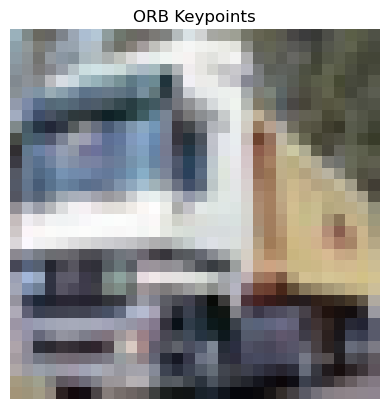

In [13]:
# 8. ORB keypoint detection (as proxy for BoVW visualization)
orb = cv2.ORB_create()
keypoints = orb.detect(gray, None)
keypoint_img = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure()
plt.imshow(keypoint_img)
plt.title("ORB Keypoints")
plt.axis('off')
plt.show()